In [1]:
# Remember to update your path
%load_ext autoreload
%autoreload 2

import sys
from datetime import date
sys.path.append('/home/runmin/Documents/Qishi/QishiQR')

from pathlib import Path

from Backtesting.Vectorized.cross_compare import *
from Backtesting.Vectorized.models import *

from Utils.lm import gen_strategy, LM_model
from Utils.MajorContract_split import MajorContracts

import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from helper import data_loader, get_direction, to_categorical, to_label, predict


# ====== Initial Configuration ========

try:
    with open('../config.json','r') as f:
        config = json.load(f)
except:
    print("Failed to find the configuration file.")
        
DATA_DIR = config['Tick path']
OUTPUT_DIR = config['Output path']
Strategy_DIR = config['Strategy path']
Major_DIR = config['Major path']
model_order = config['Max model order']
number_of_states = config['State number']
freq = config['Frequency']
offset = config['Offset']
tca = None

# Load Data

In [12]:
start = date(2016, 1, 1)
end = date(2016, 10, 31)

start_dates = [start.strftime("%Y%m%d")]
split_dates = ['2016-7-31']
end_dates = [end.strftime("%Y%m%d")]

mj = MajorContracts(symbol='bu', split_time=split_dates[0], topdir='/home/runmin/Documents/Qishi/tick2016', 
                       maturity={'1606':['2015-11-1','2016-5-1'], 
                                 '1609':['2016-2-1','2016-8-1'], 
                                 '1612':['2016-6-1','2016-11-15'],
                                 '1706':['2016-10-15','2017-1-31']}, 
                       transitions={'1606':'2016-3-1', '1609':'2016-7-1', '1612':'2016-11-1', '1706':'2017-1-1' },
                       freq=freq, offset=offset)

mj_train, mj_test, ptb = mj.create_major_overlap()

bu1606 /home/runmin/Documents/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1606 ['2015-11-1', '2016-5-1'] 2016-01-01 00:00:00 2016-03-01 00:00:00
probability table:  20160104.0 20160229.0
bu1609 /home/runmin/Documents/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1609 ['2016-2-1', '2016-8-1'] 2016-03-01 00:00:00 2016-07-01 00:00:00
probability table:  20160229.0 20160630.0
bu1612 /home/runmin/Documents/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1612 ['2016-6-1', '2016-11-15'] 2016-07-01 00:00:00 2016-11-01 00:00:00
probability table:  20160701.0 20160729.0
bu1706 /home/runmin/Documents/Qishi/tick2016/bu
0
ID trade_range transition_begin transition_end
1706 ['2016-10-15', '2017-1-31'] 2016-11-01 00:00:00 2016-12-31 00:00:00


# Generate training labels

In [13]:
train_index, train_data = to_categorical(get_direction(mj_train), 3)
test_index, test_data = to_categorical(get_direction(mj_test), 3)

In [21]:
HIDDEN_SIZE=3
NUM_LAYERS=1

# Train with LSTM

In [22]:
model = nn.LSTM(input_size=3, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, bias=True)
# if torch.cuda.is_available():
#     device=torch.device('cuda')
#     model.to(device)
device=torch.device('cpu')
    
optimizer = optim.SGD(model.parameters(), lr=0.03,momentum=0.5, dampening=0.8)
criterion = nn.CrossEntropyLoss()

In [23]:
for epochs in range(4):
    hidden = (torch.zeros([NUM_LAYERS,1,HIDDEN_SIZE], dtype=torch.float32).to(device), torch.randn([NUM_LAYERS,1,HIDDEN_SIZE], dtype=torch.float32).to(device))
    loss_avg = 0
    for train, target in data_loader(train_data, device):
        optimizer.zero_grad()
        output, hidden = model(train, hidden)
        loss = criterion(output.float().view(1,-1), target)
        loss.backward()
        optimizer.step()
        hidden = (hidden[0].detach(), hidden[1].detach())
        loss_avg += loss
    print(loss_avg/train_data.shape[0])

tensor(0.7639)
tensor(0.7154)
tensor(0.7134)
tensor(0.7125)


In [24]:
hidden_init = (torch.zeros([NUM_LAYERS,1,HIDDEN_SIZE], dtype=torch.float32).to(device), torch.randn([NUM_LAYERS,1,HIDDEN_SIZE], dtype=torch.float32).to(device))
_, predicted_label = predict(model, test_data, hidden_init)
predicted_label = np.insert(predicted_label, 0, 0)
mj_test['signal']=predicted_label
print('Test set prediction accurancy:',(predicted_label==test_index).mean())


Test set prediction accurancy: 0.7345978642371742


# Backtest

In [29]:
from Backtesting.Vectorized.backtest import vectorizedbacktest
tester = vectorizedbacktest(mj_test, tca='None')
tester.runtest()
tester.calperformance()
tester.performance

/home/runmin/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/runmin/Documents/Qishi/QishiQR/Backtesting/Vectorized/backtest.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.result['signal_bar'][0] = 0


{'Total Number of Trades': 1806,
 'Winning Rate': 0.31118493909191586,
 'Profit Factor': 0.7697901712525066,
 'Average Daily Return': 0.003761877440101002,
 'Average Return per Trade': 0.0002145478274254724,
 'Average Positive Return': 0.002048269084019769,
 'Average Negative Return': -0.002660814804490269,
 'Max Drawdown': -0.03034434198057223,
 'Total Return': 1.3874733763304035,
 'Annualized Volatility': 0.14362382891345174,
 'Sharpe Ratio': 6.548142931017254,
 'Largest Winning Trade': 0.015252917255268691,
 'Largest Losing Trade': -0.018900906309200258}

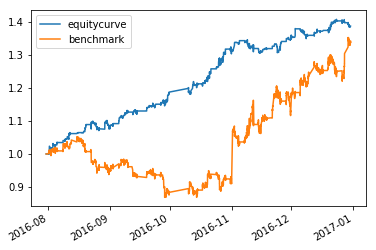

In [30]:
tester.result.equitycurve.plot()
tester.result.benchmark.plot()
plt.legend()